## TODO List

- 季/月份/小時 (representative seasons/months/hours of each type of crime)
- 跨年/州
- 多變量分析 (偽prediction)
- Presentation order: Overall -> Conditional counts -> Interesting finding

# FBI Crime Data Analysis

### Yu-Heng Lei (yuhengl1), Bo-Cheng Lin (bochengl), Xiaoyu Qiu (xiaoyuq)

## Motivation
Emerging crime incidents have raised awareness of
personnel security. Therefore, understanding factors and their
relationship with crime incidents could be useful for predicting
crimes. Security agencies may leverage this analysis to influence
decision making in order to reduce crime rates in the future. 

TODO: Avoid mentioning "predicting" crimes as suggested by Zico

TODO: More introduction and motivation

## Libraries Used


### Data Processing

For manipulating CSV tables, we’ll use packages like `pandas` and `NumPy` to preprocess the data and reorganize into data frames.


### Data Visualization

We will use `Matplotlib` and `seaborn` for exploratory analysis to convey information underlying the data.


In [1]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Data Pre-processing
Our main dataset is the National Incident-Based Reporting System (NIBRS) dataset from FBI. The data format is in CSV.

You can find the NIBRS dataset here:

- FBI crime data explorer. https://crime-data-explorer.fr.cloud.gov/downloads-and-docs

Following the collection of the data, there are 43 tables for a specific state-year combination that needs to be transformed into useful format. We also need to establish the relationships between tables, such as mapping `offense_type_id` into a *human-readable* string.

First, define the 43 table names as lists or dictionaries. We will reuse them in *loops* later. The lookup tables are stored in a dictionary of `{table_name: (oldCol, newCol)}` format.

In [2]:
# 11 primary (more important) tables
# Note that one incident is associated with up to 10 offenses
primaryTables = [
    "nibrs_arrestee", "nibrs_bias_motivation", "nibrs_incident", "nibrs_month",
    "nibrs_offender", "nibrs_offense", "nibrs_property_desc", "nibrs_property",
    "nibrs_victim_injury", "nibrs_victim_offender_rel", "nibrs_victim"
]

# 23 lookup tables as a dictionary of {table_name: (oldCol, newCol)} format
lookupTables = {
    "nibrs_activity_type": None, "nibrs_age": None, "nibrs_arrest_type": None, 
    "nibrs_assignment_type": None, "nibrs_bias_list": None, "nibrs_circumstances": None,
    "nibrs_cleared_except": None,
    "nibrs_criminal_act_type": ("criminal_act_id", "criminal_act_name"),
    "nibrs_drug_measure_type": None, "nibrs_ethnicity": None,
    "nibrs_injury": None, "nibrs_justifiable_force": None,
    "nibrs_location_type": ("location_id", "location_name"),
    "nibrs_offense_type" : ("offense_type_id", "offense_name"), "nibrs_prop_desc_type": None,
    "nibrs_prop_loss_type": None,
    "nibrs_relationship": ("relationship_id", "relationship_name"),
    "nibrs_suspected_drug_type": None, "nibrs_using_list": None,
    "nibrs_victim_type": ("victim_type_id", "victim_type_name"),
    "nibrs_weapon_type": None, "ref_race": None, "ref_state": None
}

# 9 secondary (less important, just for human differentiation) tables
secondaryTables = [
    "agency_participation", "cde_agencies", "nibrs_arrestee_weapon", "nibrs_criminal_act",
    "nibrs_suspected_drug", "nibrs_suspect_using", "nibrs_victim_circumstances",
    "nibrs_victim_offense", "nibrs_weapon"
]

The following function reads all 43 CSVs into a **dictionary of DataFrames** for a particular dataset (e.g., `SC-2016`, or South California 2016). The dictionary keys are the NIBRS table names.

In [3]:
def readCSVs(dataset):
    """
    Read DataFrames into a dictionary with table names as keys
    Args:
        dataset (string): NIBRS dataset name, e.g., SC-2016
    Return:
        dic (dictionary): dictionary of DataFrames
    """
    print('Reading all CSVs for %s dataset...' % dataset)
    dic = {}
    for table in primaryTables + list(lookupTables.keys()) + secondaryTables:
        dic[table] = pd.read_csv("%s/%s.csv" % (dataset, table))
    print('Finished reading %d CSVs' % len(dic))
    return dic

SC2016 = readCSVs('SC-2016')
# PA2016 = readCSVs('PA-2016')

Reading all CSVs for SC-2016 dataset...
Finished reading 43 CSVs


To replace those *id*'s with human-readable strings, we will first create a nested dictionary of `{(oldCol, newCol): {oldValue: newValue}}` format from a lookup table. This nested dictionary can be reused by any dataset.

Following the style of the previous cell, we use a for loop to create a nested dictionary.

In [4]:
# Replace a col with a specified mapping dict:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html
# https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
def createMappings(dfs):
    """
    Create a nested dictionary of mappings 
    Args:
        dfs (dictionary): dictionary of DataFrames previously read
    Return:
        mappings (nested dictionary): {(oldCol, newCol): {oldValue: newValue}}
    """
    print('Creating lookup table mappings...')
    mappings = {}
    for table in lookupTables:
        # Only handle those with defined mapping
        if lookupTables[table] is not None:
            oldCol, newCol = lookupTables[table]
            mappings[(oldCol, newCol)] = dict(zip(dfs[table][oldCol], dfs[table][newCol]))
    print('Finished creating mappings from %d lookup tables' % len(mappings))
    return mappings

maps = createMappings(SC2016)

Creating lookup table mappings...
Finished creating mappings from 5 lookup tables


Finally, using the previously created nested dictionary, we will call [DataFrame.replace()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) with another nested dictionary argument of `{oldCol: {oldValue, newValue}}` format to perform the replacement in place. Also, we will rename this `oldCol` as `newCol` for better readability.

In [5]:
def replaceAndRename(df, lookupTableNames):
    """
    Replace and rename DataFrame columns in place.
    Args:
        df (DataFrame): DataFrame to be replaced
        lookupTableNames (list): List of lookup table names for replacing and renaming
    """
    # Call df.replace() and df.rename() once for each changing column
    for lookupTableName in lookupTableNames:
        # Build the nested dictionary required by df.replace()
        oldCol, newCol = lookupTables[lookupTableName]
        dic = {oldCol: maps[(oldCol, newCol)]}        
        df.replace(dic, inplace=True)
        df.rename(columns={oldCol: newCol}, inplace=True)

print('Replacing and Renaming columns...')
replaceAndRename(SC2016['nibrs_offense'], ['nibrs_location_type', 'nibrs_offense_type'])
replaceAndRename(SC2016['nibrs_victim'], ['nibrs_victim_type'])
replaceAndRename(SC2016['nibrs_victim_offender_rel'], ['nibrs_relationship'])
print('Done')
# SC2016['nibrs_offense'].head()
# SC2016['nibrs_victim'].head()

Replacing and Renaming columns...
Done


## Exploratory Data Analysis
With the transformed crime data, we will make exploratory data analysis (histogram/scatter
plot/basic statistics) to determine the dominant types of features. On
the basis of these features, we could train base models to predict the
possible features of the offender(race, age, sex, relationship with
victim) given resolved incidents using ML algorithm (LR, DT, NN, SVM,
etc.) and select the best model with validation data, and set it as
the base model.


In [6]:
# Helper function for plotting sns.countplot given df, col, and topK
def countPlot(df, col, topK=None, dpi = 100):
    plt.figure(figsize=(8,6), dpi=dpi)
    # Only show top K counts. Default: all counts
    sns.countplot(y = df[col], order = df[col].value_counts().index[:topK])

Plot the distribution of all victim types.

0.193979% (762 / 392827) of victims are Law Enforcement Officers


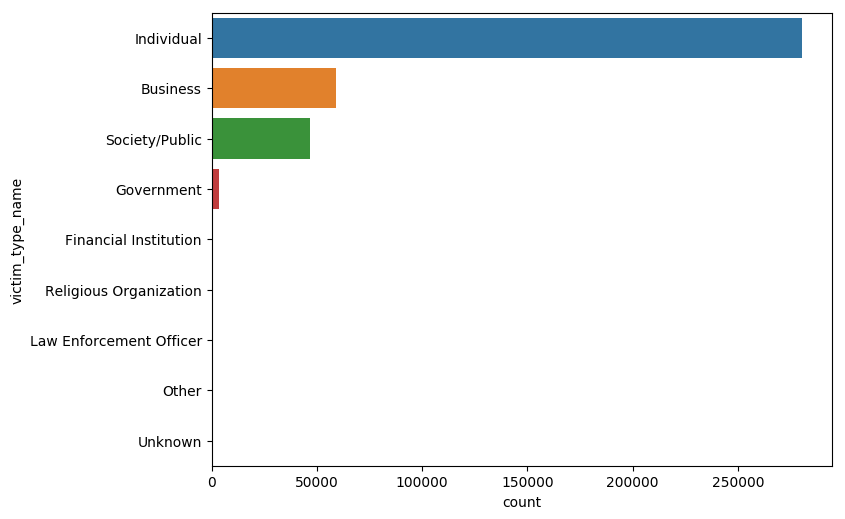

In [7]:
victimDF = SC2016['nibrs_victim']
officerVictimCount = (victimDF['victim_type_name'] == 'Law Enforcement Officer').sum()
allVictimCount = len(victimDF)
print('%f%% (%d / %d) of victims are Law Enforcement Officers' % 
     (officerVictimCount / allVictimCount * 100, officerVictimCount, allVictimCount))
countPlot(victimDF, 'victim_type_name')

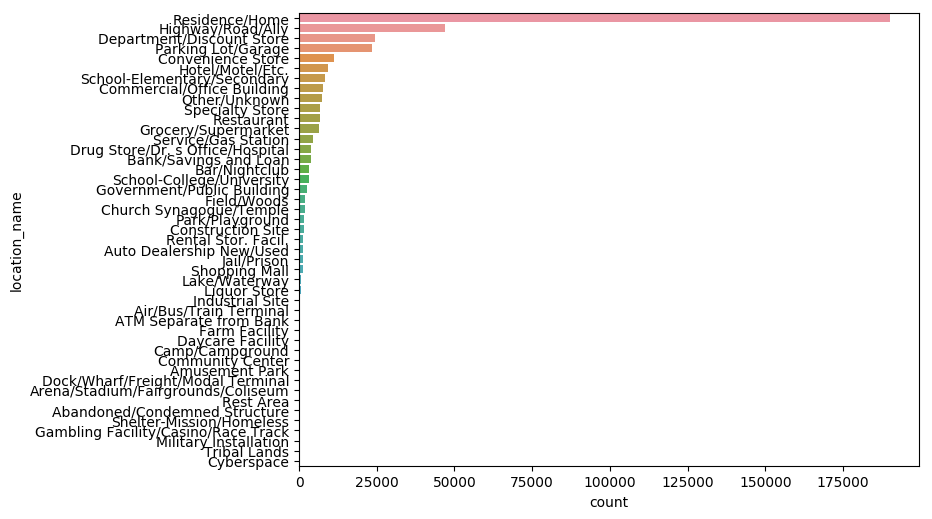

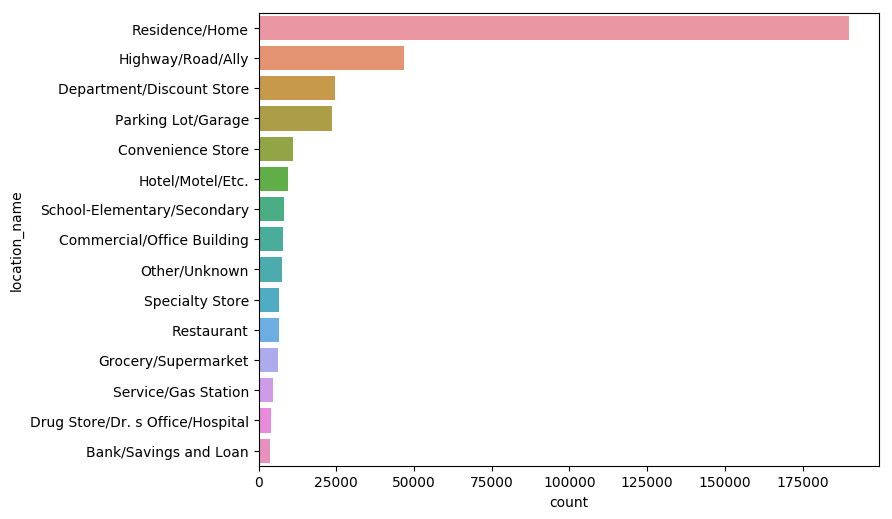

In [8]:
countPlot(SC2016['nibrs_offense'], 'location_name')
countPlot(SC2016['nibrs_offense'], 'location_name', topK=15)

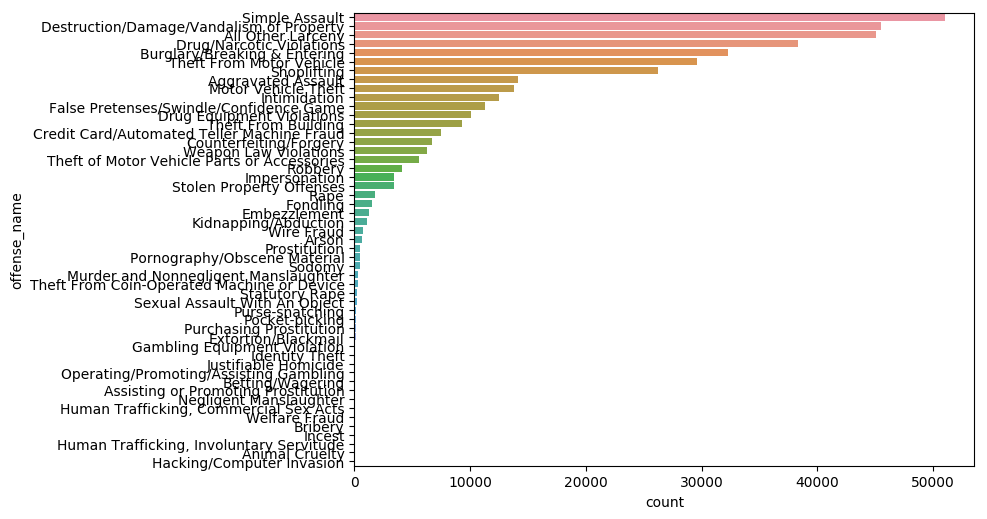

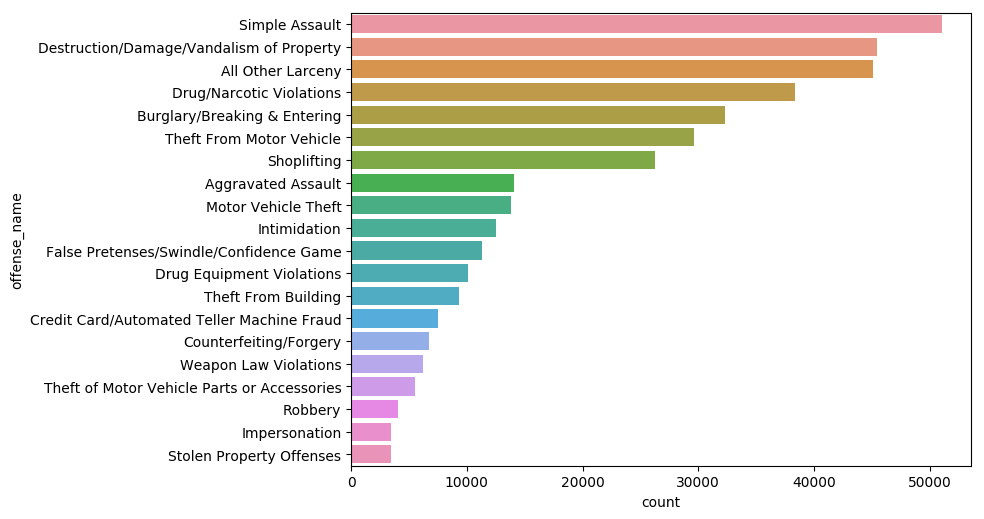

In [9]:
countPlot(SC2016['nibrs_offense'], 'offense_name')
countPlot(SC2016['nibrs_offense'], 'offense_name', topK=20)

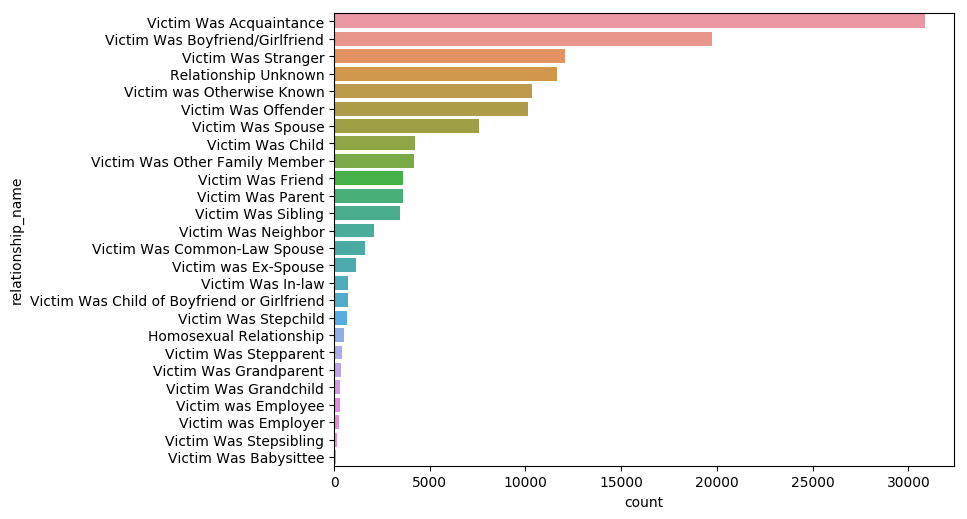

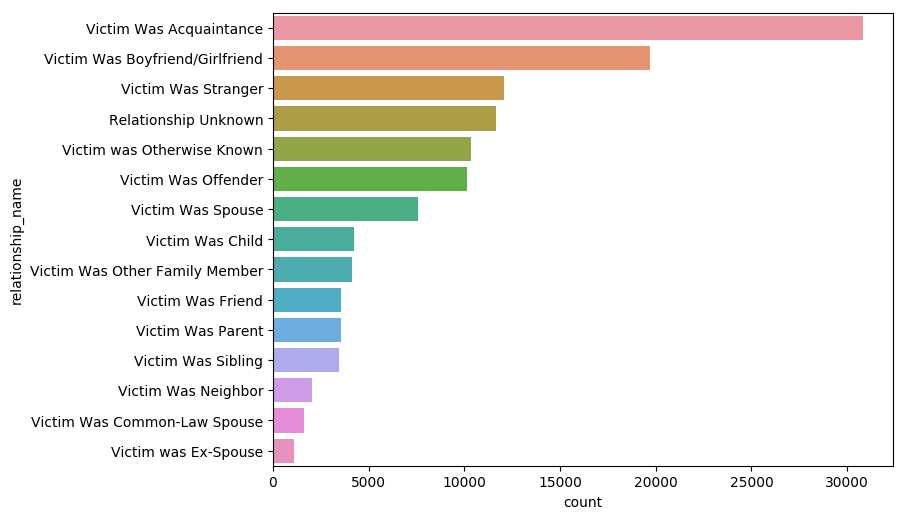

In [10]:
countPlot(SC2016['nibrs_victim_offender_rel'], 'relationship_name')
countPlot(SC2016['nibrs_victim_offender_rel'], 'relationship_name', topK=15)